# We need to convert SDSS MJD to barycentric time, and Gaia OBMT to barycentric time, then average over visits. Note not all Gaia visits contribute to spectrum

In [1]:
import pandas as pd
import numpy as np

from astropy import time, coordinates as coord, units as u

# We've done this calculation already to compute the Barycentric SDSS observation times

```python
query_blue = pd.read_csv('../data/GaiaQueries/DR3_SDSS_spectra_g_lt_16_ug_lt_0p6-result.csv')
query_red = pd.read_csv('../data/GaiaQueries/DR3_SDSS_spectra_g_lt_16-result.csv')

query = pd.concat((query_red, query_blue))

apo_loc = coord.EarthLocation.of_site('apo')

sdss_mjd = time.Time(query.mjd, format='mjd', scale='utc',location=apo_loc)
sdss_coo = coord.SkyCoord(query.ra, query.dec, frame='icrs', unit=u.deg)

ltt_bary = sdss_mjd.light_travel_time(sdss_coo)

time_barycentre = sdss_mjd.tdb + ltt_bary 
```

# And the Gaia scanning law-based times

```python
j_2015 = time.Time('2015.0', format='jyear', scale='tdb')

import scanninglaw.times as times
from scanninglaw.source import Source
#ScanningLaw: Everall et al. 2021
# Convert to barycentre: Gaia collab. 2016, eq (3)

dr3_sl = times.Times(version='dr3_nominal')

from tqdm.notebook import tqdm

mean_times = []
for i, row in tqdm(query.iterrows(), total=len(query)):
    s = Source(row.ra, row.dec, frame='icrs', unit='deg')
    result = dr3_sl(s)
    visit_obmt = np.sort(np.hstack(result['times']))[0]
    visit_tcb = np.array([time.Time((obmt - 1717.6256)/1461, format='jyear', scale='tdb').value + j_2015.value for obmt in visit_obmt])
    mean_tcb = time.Time(np.mean(visit_tcb), format='jyear', scale='tdb')
    mean_times.append(mean_tcb.mjd)
mean_times = np.array(mean_times)

out_df = pd.DataFrame({'mean_xp_bjd':mean_times, 'sdss_bjd':time_barycentre.mjd}, index=query.source_id)
out_df.to_csv('../data/OutputFiles/obs_times.csv', index=True)
```

In [2]:
# Now let's inspect the results
time_df = pd.read_csv('../data/OutputFiles/obs_times.csv', index_col=0)
time_df.head()

,mean_xp_bjd,sdss_bjd
source_id,,
5041740170358770944,57176.470449,54061.003939
3504476267364687232,57166.948324,51667.006186
6240929124265524096,57135.862350,53527.006320
6279444260669526784,57126.819364,53880.006120
5458335780274988032,57136.478267,53764.004158


10.525151704075592


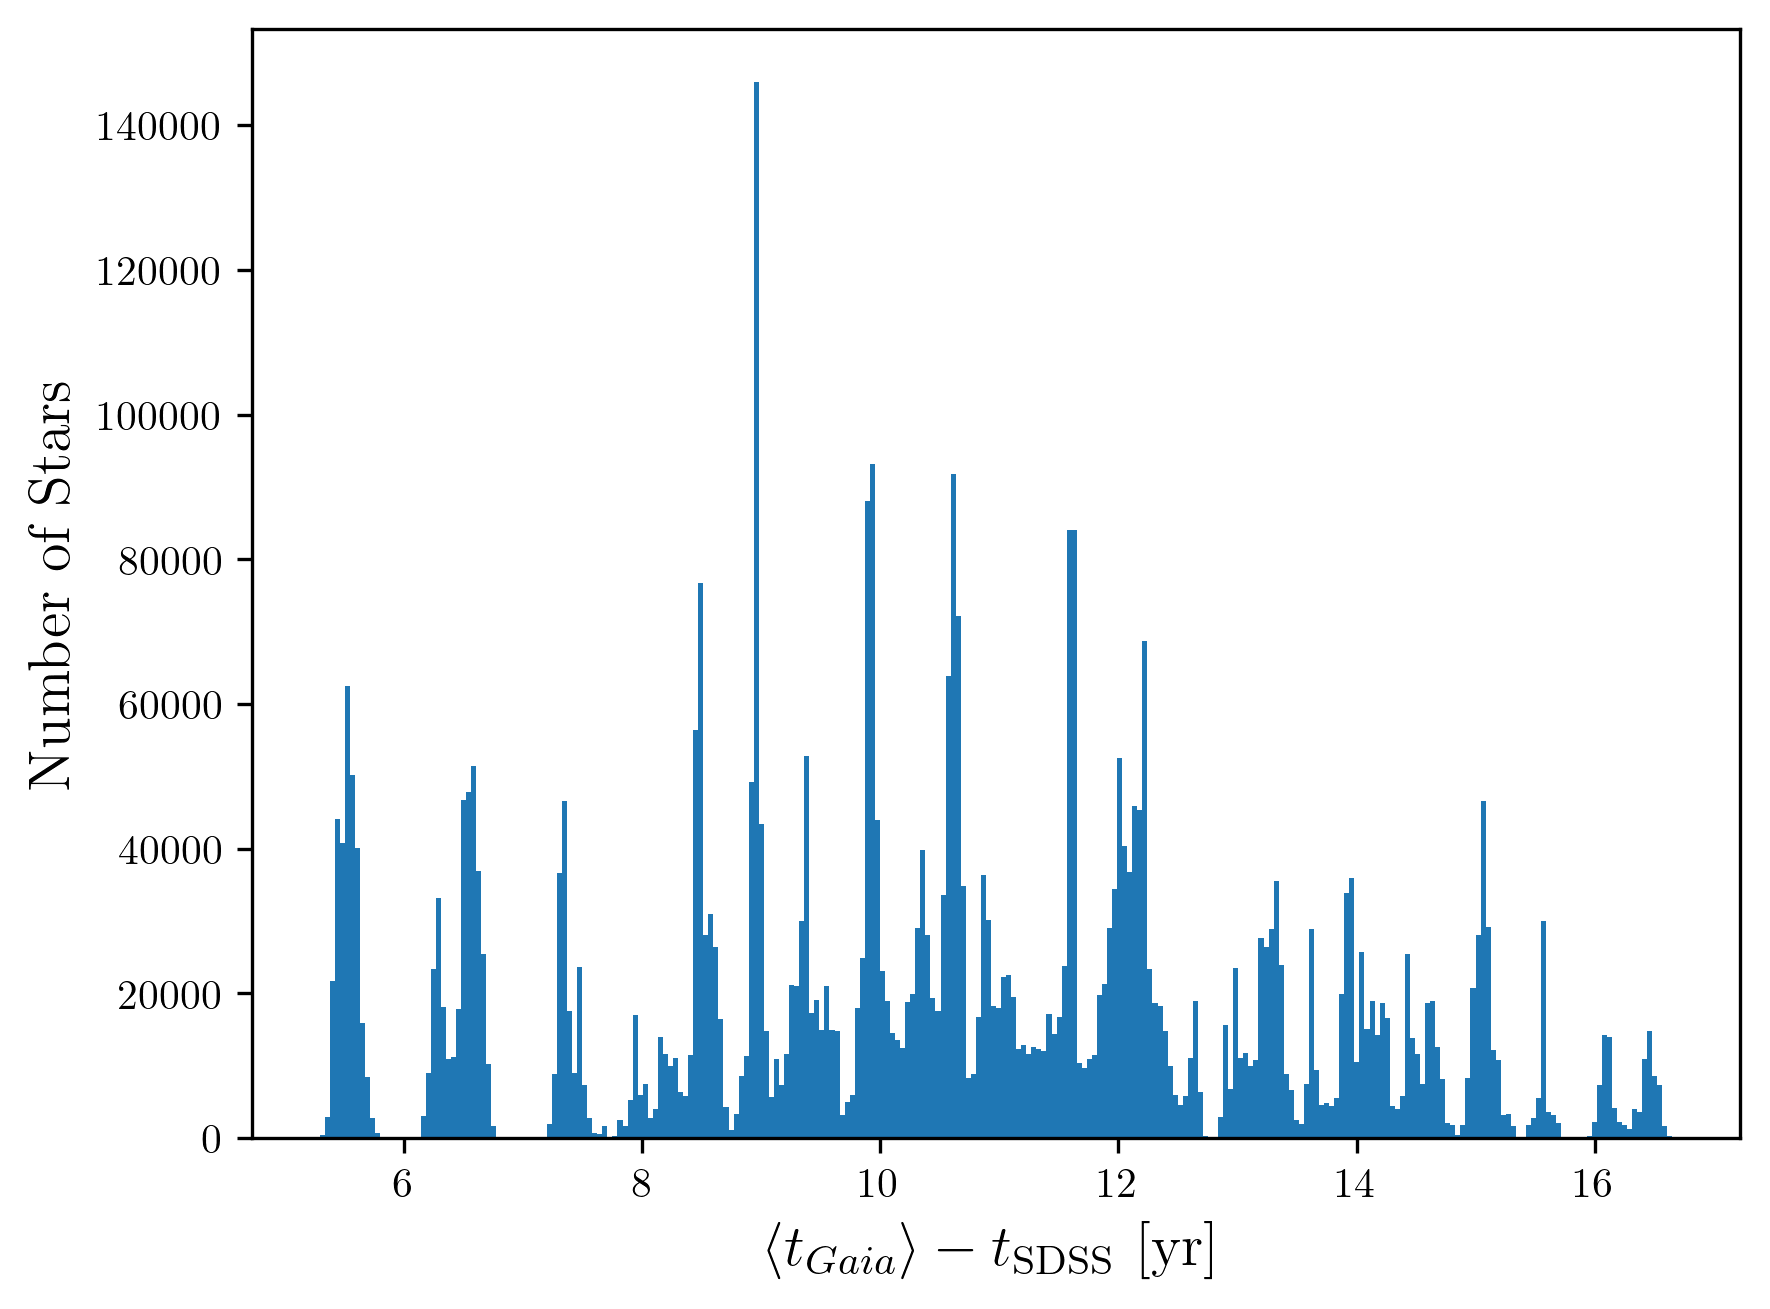

In [3]:
from matplotlib import pyplot as plt

fig = plt.figure(dpi=300)
plt.hist((time_df['mean_xp_bjd']-time_df['sdss_bjd'])/365.25,bins='auto',rasterized=True)
print(np.mean(time_df['mean_xp_bjd']-time_df['sdss_bjd'])/365.25)

plt.xlabel(r'$\langle t_{Gaia} \rangle - t_{\rm SDSS}$ [yr]', fontsize=14)
plt.ylabel('Number of Stars', fontsize=14)

plt.savefig('../plots/dt_hist.pdf', bbox_inches='tight')